# Study of [EPIC248847494](https://exofop.ipac.caltech.edu/k2/edit_target.php?id=248847494)

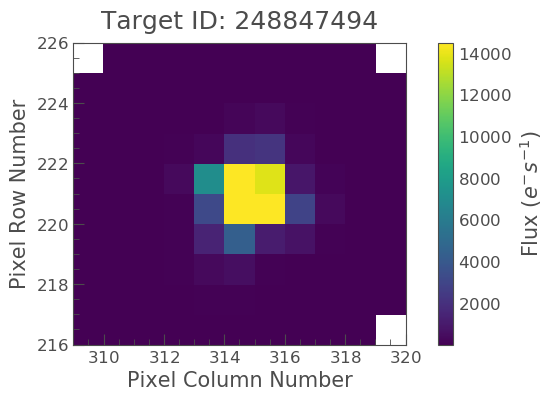

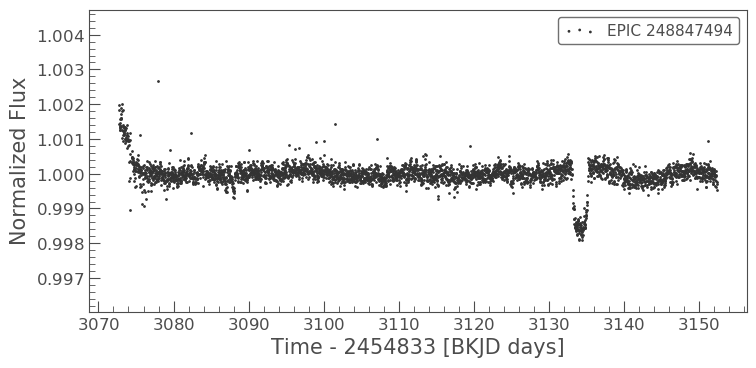

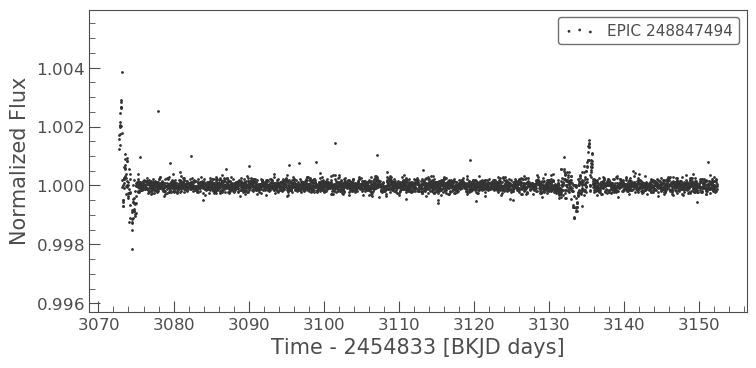

In [84]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
from astropy.stats import BoxLeastSquares
import matplotlib.pyplot as plt
import math

target = '248847494'

tpf = search_targetpixelfile(target).download()
tpf.plot()
lc = search_lightcurvefile(target).download().PDCSAP_FLUX.remove_nans()
lc.scatter()
corr_lc = lc.to_corrector("sff").correct(windows=40)
corr_lc_f, trend = corr_lc.flatten(window_length=401, return_trend=True)
corr_lc_f.scatter()

We can see a clear transit in the first lightcurve, and in the corrected one, we see a second dip at the beginning of the curve. We'll use the corrected one to approximate the period, and the first light curve to fit the data:

(<Time object: scale='tdb' format='jd' value=2457915.3578716065>,
 <Quantity 58.93883898 d>)

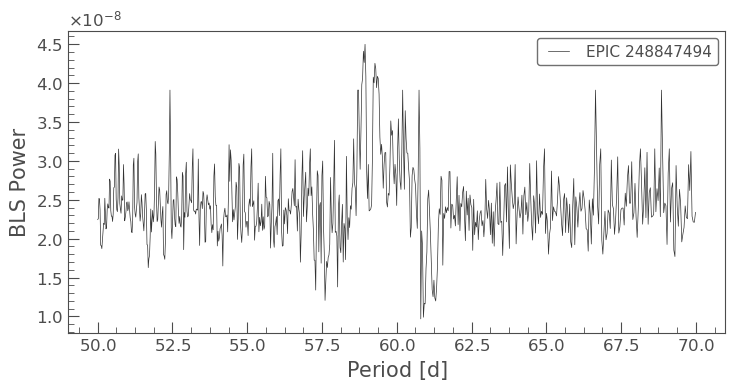

In [92]:
pg = corr_lc.to_periodogram("bls", minimum_period=50, maximum_period=70, frequency_factor=1, duration=0.05)
pg.plot();
pg.transit_time_at_max_power+corr_lc.astropy_time[0], pg.period_at_max_power,

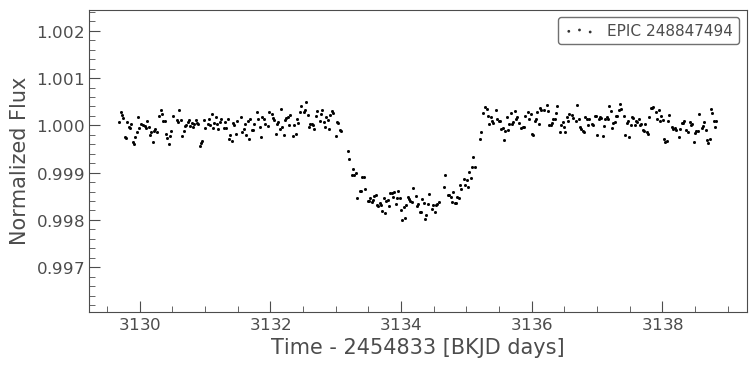

In [85]:
lc_transit = lc[2600:3000].normalize()
lc_transit.scatter()
lc.time_format = 'jd'
plt.scatter(lc_transit.time, lc_transit.flux, s=1, c='k')
plt.savefig('transit.png')

### **Potential planet**
but we have just one transit so it is hard to say. We'll try fitting the curve using batman:

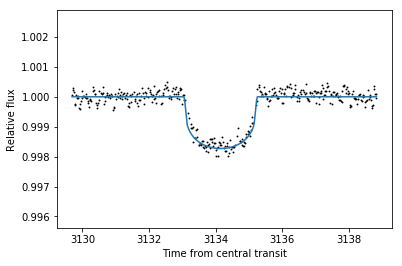

In [120]:
import batman #package by Laura Kreidberg:  http://astro.uchicago.edu/~kreidberg/batman/

params = batman.TransitParams()
params.t0 = 3134.15                      #time of inferior conjunction
params.per = 58.9388                      #orbital period
params.rp = 0.038                      #planet radius (in units of stellar radii)
params.a = 8.1                     #semi-major axis (in units of stellar radii)
params.inc = 87                   #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [0.5528, 0.1548]                #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"

t = np.linspace(lc_transit[0].time, lc_transit[-1].time, len(lc_transit.flux))    #where the transit is

m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)  #calculates light curve

plt.scatter(lc_transit.time, lc_transit.flux, s=.8, c='k')
plt.plot(t, flux)
plt.xlabel("Time from central transit")
plt.ylabel("Relative flux")
plt.show()

In [121]:
import emcee  #package by Dan Foreman-Mackey:  http://dan.iel.fm/emcee/current/
import corner #package by Dan Foreman-Mackey:  http://corner.readthedocs.io/en/latest/

#intialize a transit model
def initialize_model(t, t0, per, rp, a, inc, ecc, w, u, limb_dark):
	params = batman.TransitParams()
	params.t0 = t0 
	params.per = per
	params.rp = rp
	params.a = a
	params.inc = inc
	params.ecc = ecc
	params.w = w
	params.u = u
	params.limb_dark = limb_dark      

	model = batman.TransitModel(params, t)

	return params, batman.TransitModel(params, t)    #return parameters and model objects 

#prior
def lnprior(theta):
	return 0.  #assumes all priors have uniform probability

#likelihood function 
def lnlike(theta, params, model, t, flux, err):
    params.rp, params.a, params.inc = theta[0], theta[1], theta[2]
    params.t0 = theta[3]
    params.per = theta[4]
    lc = model.light_curve(params)
    residuals = flux - lc
    ln_likelihood = -0.5*(np.sum((residuals/err)**2 + np.log(2.0*np.pi*(err)**2)))

    return ln_likelihood

#posterior probability
def lnprob(theta, params, model, t, flux, err):
	lp = lnprior(theta)
	if not np.isfinite(lp):
		return -np.inf
	return lp + lnlike(theta, params, model, t, flux, err)

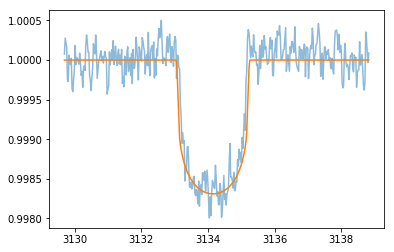

In [117]:
t = np.linspace(lc_transit[0].time, lc_transit[-1].time, len(lc_transit.flux))    #where the transit is

#Now for some initial parameter guesses
t0 = 3134.15                      #time of inferior conjunction
per = 58.9388                     #orbital period
rp = 0.038                      #planet radius (in units of stellar radii)
a = 8.1                     #semi-major axis (in units of stellar radii)
inc = 87                   #orbital inclination (in degrees)
ecc = 0.                      #eccentricity
w = 90.                       #longitude of periastron (in degrees)
u = [0.5528, 0.1548]                #limb darkening coefficients [u1, u2]
limb_dark = "quadratic"

#initialize model and parameters
params, m = initialize_model(t, t0, per, rp, a, inc, ecc, w, u, limb_dark)

#compare your initial guess with the data and make adjustments
plt.plot(t, lc_transit.flux, alpha=.5) #blue
plt.plot(t, m.light_curve(params)) #green

In [104]:
#now let's get the MCMC initialized
#initial guesses for MCMC fit parameters from your by eye fits
#for simplicity we will only fit for Rp/R*, limb darkening coefficient, and center of transit time
guess_rp, guess_a, guess_i = 0.038, 8.1, 87
guess_t0 = 3134.15
guess_per = 58.9388
theta = [guess_rp, guess_a, guess_i, guess_t0, guess_u1, guess_u2, guess_per]

In [105]:
#initialize sampler
err = 100.e-6
ndim, nwalkers = len(theta), 200
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = (params, m, t, lc_transit.flux, err))
pos = [theta + 1e-5*np.random.randn(ndim) for i in range(nwalkers)]

In [106]:
#run mcmc
sampler.run_mcmc(pos,500);

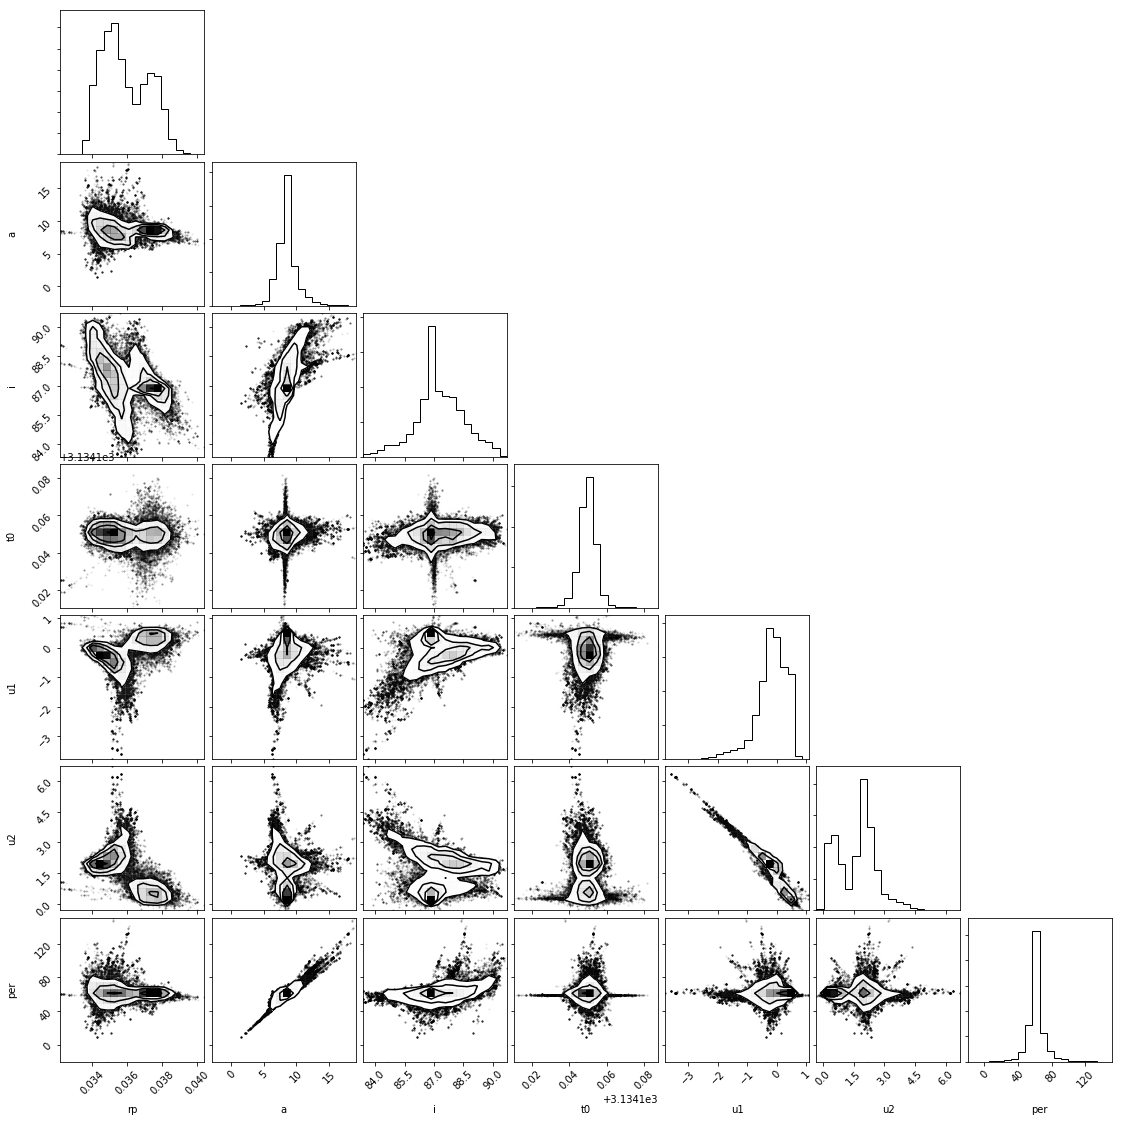

In [107]:
#make a pairs plot from MCMC output
import corner
samples = sampler.chain[:, 50:, :].reshape((-1, ndim)) #discard first 50 samples as burn-in
fig = corner.corner(samples, labels = ["rp", "a", "i", "t0", "u1", "u2", "per"])
plt.show()

In [108]:
#Now we need to derive the best-fit planet parameters and their 1-sigma error bars
rp_mcmc, a_mcmc, i_mcmc, t0_mcmc, u1_mcmc, u2_mcmc, per_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print(rp_mcmc)
print(a_mcmc)
print(i_mcmc)
print(t0_mcmc)
print(u1_mcmc)
print(u2_mcmc)
print(per_mcmc)

(0.03561534509024176, 0.001891077977646538, 0.0010841122409482526)
(8.32968089396164, 1.421580585208229, 1.05789585803673)
(87.12533992114236, 1.361855757967902, 0.881499961567286)
(3134.1497187523087, 0.003971166760948108, 0.004317615199397551)
(-0.13047222740936842, 0.47148176098116124, 0.4952719429823516)
(1.84154452197606, 0.6429613885764058, 1.3785676298126848)
(59.050339921812984, 8.709608708769089, 3.758033045605451)


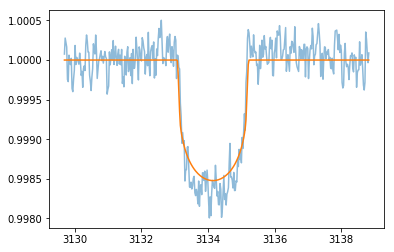

In [119]:
#Now for the final parameter to check
t0 = t0_mcmc[0]  #time of inferior conjunction 
per = per_mcmc[0]  #orbital period -> contrained from other observations
rp = rp_mcmc[0]  #planet radius (in units of stellar radii)
a = a_mcmc[0]   #semi-major axis (in units of stellar radii)
inc = i_mcmc[0] #orbital inclination (in degrees)
ecc = 0  #eccentricity  -> Let's assume for now that the planet is not on an eccentric orbit
w = 90   #longitude of periastron (in degrees) 
u = [0.5528, 0.1548]  #limb darkening coefficients
limb_dark = "quadratic" #limb darkening model -> Simple limb darkening model, need to consider other models

params, m = initialize_model(t, t0, per, rp, a, inc, ecc, w, u, limb_dark)

#compare your initial guess with the data and make adjustments
plt.plot(t, lc_transit.flux, alpha=.5) #black
plt.plot(t, m.light_curve(params)) #green